In [1]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from datetime import datetime 
from datetime import timedelta 

import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import requests
import json

import warnings
warnings.filterwarnings('ignore')

/Users/guangyecao/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Aggregate Analysis

In [11]:
wETH_dailyMarket = pd.read_csv('wETH_borrow_dailyMarketSnapshots.csv')

wETH_dailyMarket['protocol'] = np.where(wETH_dailyMarket['protocol']=="spark_arbitrum", "spark_ethereum", wETH_dailyMarket['protocol'])
wETH_dailyMarket['protocol-asset'] = np.where(wETH_dailyMarket['protocol-asset']=="spark_arbitrum_wETH", "spark_ethereum_wETH", wETH_dailyMarket['protocol-asset'])
#print(wETH_dailyMarket['protocol-asset'].unique())

#print(wETH_dailyMarket['protocol'].unique())
wETH_dailyMarket['date'] = pd.to_datetime(wETH_dailyMarket['date'])
wETH_dailyMarket['date'] = wETH_dailyMarket['date'].dt.date

wETH_dailyMarket_trunc = wETH_dailyMarket.loc[wETH_dailyMarket['days']>=19507]

wETH_dailyMarket_trunc.set_index('date', inplace=True)


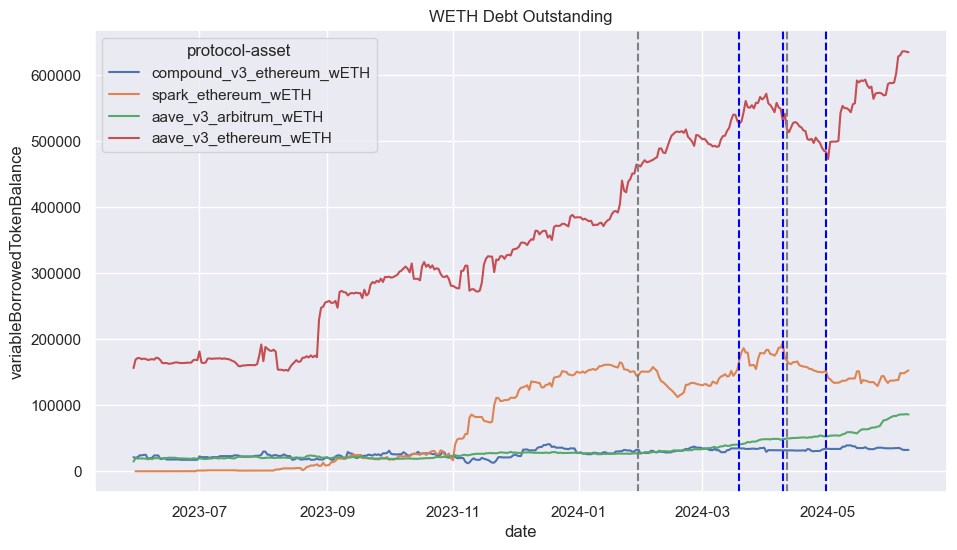

In [12]:
fig, ax = plt.subplots(figsize=(11, 6))
#sns.lineplot(data=df, x='Date', y='Adj Close', hue='ticker', ax=ax)

sns.lineplot(data=wETH_dailyMarket_trunc, x = 'date', y='variableBorrowedTokenBalance', hue = 'protocol-asset', ax = ax).set_title("WETH Debt Outstanding")
ax.axvline(pd.to_datetime("2024-01-30"), color="grey", linestyle="--", label="Merit Temp Check")
#ax.axvline(pd.to_datetime("2024-02-16"), color="grey", linestyle="--", label="Merit ARFC")
ax.axvline(pd.to_datetime("2024-04-11"), color="grey", linestyle="--", label="Merit Forever")
ax.axvline(pd.to_datetime("2024-03-19"), color="blue", linestyle="--", label="First distribution")
ax.axvline(pd.to_datetime("2024-04-09"), color="blue", linestyle="--", label="Second distribution")
ax.axvline(pd.to_datetime("2024-04-30"), color="blue", linestyle="--", label="Third distribution")


### Differences-in-differences

- Calculate the before and after differences for control and treatment groups, and then calculate the difference of the differences

Pre-Merit = 11/01/2023 - 01/29/2024

Post-Merit = 1/30/2024 - 4/30/2024 



| Protocol          | Period | Average daily WETH borrowed | First Difference | Second Difference|
|:--------:|:--------:|:--------:|:--------:|:--------:|
|  Aave Ethereum v3   | Pre-Merit   | 354490.5   | 159815.2     |   131887     |
|                     |  Post-Merit |  514305.7  |       |         |
|  Spark Ethereum     |  Pre-Merit  |  123527.8  |        |         |
|                     | Post-Merit  |  151455.8  |   27927.9   |         |

#### As Regression
$$
    Y_{it} = \beta_{0} + \beta_{1} AaveDummy_{i} + \beta_{2} PostMerit_{t} + \beta_{3} AaveDummy_{i}*PostMerit_{t} + \epsilon_{it}
$$

#### Assumptions:
1. Parallel Trends: treatment and control moved in sync in the Pre-Merit period.
2. No Anticipation
3. No spillover effects: independence between treatment and control groups (Violated)
4. No time varying confounders

#### Note:
1. Increase in borrowing on Aave and Spark in March corresponds with decrease on Morpho Optimizer Aave V3. Why would that affect Spark?

In [14]:
wETH_dailyMarket_trunc.reset_index(inplace=True)
wETH_dailyMarket_trunc['post'] = np.where((wETH_dailyMarket_trunc['date']>=pd.to_datetime('2024-01-30').date()) & (wETH_dailyMarket_trunc['date']<=pd.to_datetime('2024-04-30').date()),1,np.nan)
wETH_dailyMarket_trunc['post'] = np.where((wETH_dailyMarket_trunc['date']<pd.to_datetime('2024-01-30').date()) & (wETH_dailyMarket_trunc['date']>=pd.to_datetime('2023-11-01').date()),0, wETH_dailyMarket_trunc['post'])

period_data = wETH_dailyMarket_trunc.loc[wETH_dailyMarket_trunc['post'].notna() & wETH_dailyMarket_trunc['protocol-asset'].isin(['spark_ethereum_wETH', 'aave_v3_ethereum_wETH'])]
period_data['treated'] = np.where(period_data['protocol-asset']=='aave_v3_ethereum_wETH', 1, 0)

In [15]:
DiD_data = period_data.groupby(['protocol-asset', 'post']).agg({'variableBorrowedTokenBalance':'mean', "date":'min', 'treated':'max'}).reset_index()
DiD_data['variableBorrowedTokenBalance'] = DiD_data['variableBorrowedTokenBalance'].astype('float')

import statsmodels.formula.api as smf
m = smf.ols('variableBorrowedTokenBalance ~ treated*post', data = DiD_data).fit()

m.params['treated:post']


131887.2325708767

In [22]:
### Manual Difference

print("aave pre-merit: ", DiD_data['variableBorrowedTokenBalance'][0])
print("aave post-merit: ", DiD_data['variableBorrowedTokenBalance'][1])
print("spark pre-merit: ", DiD_data['variableBorrowedTokenBalance'][2])
print("spark post-merit: ", DiD_data['variableBorrowedTokenBalance'][3])

print("aave 1st difference: ", DiD_data['variableBorrowedTokenBalance'][1] - DiD_data['variableBorrowedTokenBalance'][0])
print("Spark 1st difference: ", DiD_data['variableBorrowedTokenBalance'][3] - DiD_data['variableBorrowedTokenBalance'][2])

print("second difference: ", DiD_data['variableBorrowedTokenBalance'][1] - DiD_data['variableBorrowedTokenBalance'][0] - (DiD_data['variableBorrowedTokenBalance'][3] - DiD_data['variableBorrowedTokenBalance'][2]))

aave pre-merit:  354490.520068493
aave post-merit:  514305.7042652393
spark pre-merit:  123527.84377716953
spark post-merit:  151455.79540303932
aave 1st difference:  159815.18419674633
Spark 1st difference:  27927.951625869784
second difference:  131887.23257087654


In [2]:
variabledebtWETH = pd.read_csv("variabledebtWETH_transactions_bigquery.csv", index_col=None)

variabledebtWETH['date'] = pd.to_datetime(variabledebtWETH['date'])
variabledebtWETH['block_timestamp'] = pd.to_datetime(variabledebtWETH['block_timestamp'])




### Number of unique users with positive balance on each

In [3]:
### calculate daily balance of all users on aave and spark

variabledebtWETH['transfer_value'] = np.where(variabledebtWETH['to_address']=="0x0000000000000000000000000000000000000000", variabledebtWETH['transfer_value']*(-1), variabledebtWETH['transfer_value'])

variabledebtWETH['user'] = np.where(variabledebtWETH['from_address']!="0x0000000000000000000000000000000000000000", variabledebtWETH['from_address'], variabledebtWETH['to_address'])

## cumulative sum of transactions for each user on each platform
variabledebtWETH.sort_values(['token_address','user','block_timestamp'], ascending = True, inplace =True)

variabledebtWETH['cumulative_transfer'] = variabledebtWETH.groupby(['user', 'token_address'])['transfer_value'].cumsum()

## daily balance
WETH_daily = variabledebtWETH.groupby(['user', 'token_address','date']).agg({'transaction_hash':'last', "block_timestamp":"last",'cumulative_transfer':'last'})

## indicator for positive balance address and days 
WETH_daily['positive'] = np.where(WETH_daily['cumulative_transfer']>0, 1,0)

## NOTE:
#There are some addresses that borrowed and repaid the same amount each day, so their end of day balance is 0. For example:
# 1. 0x00000000032962b51589768828ad878876299e14 is an MEV bot

In [44]:

## identify the addresses that are in both aave and spark, before and after 

## set of spark users before 01/30/2024 (token_address = 0x2e7576042566f8d6990e07a1b61ad1efd86ae70d)
## NOTE that this is WETH_daily, not WETH_daily2, because we only want days with transactions.

#WETH_daily.reset_index(inplace = True)

sparkUser_pre = set(WETH_daily.loc[(WETH_daily['token_address']=="0x2e7576042566f8d6990e07a1b61ad1efd86ae70d") & (WETH_daily['date']<'2024-01-30')]['user'])
sparkUser_post = set(WETH_daily.loc[(WETH_daily['token_address']=="0x2e7576042566f8d6990e07a1b61ad1efd86ae70d") & (WETH_daily['date']>='2024-01-30')]['user'])
sparkUser_all = sparkUser_pre.union(sparkUser_post)
sparkUser_post_only = sparkUser_all.difference(sparkUser_pre)

aaveUser_pre = set(WETH_daily.loc[(WETH_daily['token_address']=="0xea51d7853eefb32b6ee06b1c12e6dcca88be0ffe") & (WETH_daily['date']<'2024-01-30')]['user'])
aaveUser_post = set(WETH_daily.loc[(WETH_daily['token_address']=="0xea51d7853eefb32b6ee06b1c12e6dcca88be0ffe") & (WETH_daily['date']>='2024-01-30')]['user'])
aaveUser_all = aaveUser_pre.union(aaveUser_post)
aaveUser_post_only = aaveUser_all.difference(aaveUser_pre)

print("# of unique Spark WETH borrowers before 1/30/2024: ", len(sparkUser_pre))

print("# of unique Aave WETH borrowers before 1/30/2024: ", len(aaveUser_pre))

print("# of unique Spark WETH borrowers overall: ", len(sparkUser_all))

print("# of unique Aave WETH borrowers overall: ", len(aaveUser_all))

print("")

# aave users who used Spark pre-Merit
aave_spark_pre = aaveUser_all.intersection(sparkUser_pre)
print("Aave users who used Spark pre-Merit: ", len(aave_spark_pre))

#  spark users who used Aave pre-Merit
spark_aave_pre = sparkUser_all.intersection(aaveUser_pre)
print("Spark users who used Aave pre-Merit: ",len(spark_aave_pre))

# aave users who used spark during any period = spark users who used aave during any period
aave_spark_all = sparkUser_all.intersection(aaveUser_all)
print("Intersection of all Aave and Spark users: ",len(aave_spark_all))

aave_never_spark = aaveUser_all - aave_spark_all 
print("Aave users who never used Spark: ",len(aave_never_spark))

spark_never_aave = sparkUser_all - aave_spark_all 
print("Spark users who never used Aave: ", len(spark_never_aave))


# of unique Spark WETH borrowers before 1/30/2024:  138
# of unique Aave WETH borrowers before 1/30/2024:  2467
# of unique Spark WETH borrowers overall:  292
# of unique Aave WETH borrowers overall:  4054

Aave users who used Spark pre-Merit:  33
Spark users who used Aave pre-Merit:  46
Intersection of all Aave and Spark users:  66
Aave users who never used Spark:  3988
Spark users who never used Aave:  226


In [24]:
#WETH_daily.reset_index(inplace=True)

WETH_daily.set_index(['user', 'token_address', 'date'], inplace=True)

new_index = pd.MultiIndex.from_product(WETH_daily.index.levels)

WETH_daily2 = WETH_daily.reindex(new_index)

WETH_daily2['cumulative_transfer2'] = WETH_daily2.groupby(['user', 'token_address'])['cumulative_transfer'].ffill()

## active addresses have either positive balance or made transactions on a given day
WETH_daily2['active'] = np.where((WETH_daily2['cumulative_transfer2']>0) | (WETH_daily2['transaction_hash'].notna()), 1,0)

WETH_daily2['positive'] = np.where((WETH_daily2['cumulative_transfer2']>0), 1,0)

WETH_daily2.reset_index(inplace=True)

In [46]:
# indicator for aave users who also used spark pre-merit:
WETH_daily2['aave_spark_pre'] = np.where(WETH_daily2['user'].isin(aave_spark_pre), 1, 0)
#print(WETH_daily2.loc[WETH_daily2['aave_spark_pre']==1]['user'].nunique())

WETH_daily2['spark_aave_pre'] = np.where(WETH_daily2['user'].isin(spark_aave_pre), 1, 0)
#print(WETH_daily2.loc[WETH_daily2['spark_aave_pre']==1]['user'].nunique())

WETH_daily2['aave_spark_all'] = np.where(WETH_daily2['user'].isin(aave_spark_all), 1, 0)
#print(WETH_daily2.loc[WETH_daily2['aave_spark_all']==1]['user'].nunique())

WETH_daily2["aaveUser_post_only"] = np.where(WETH_daily2['user'].isin(aaveUser_post_only), 1, 0)

WETH_daily2["sparkUser_post_only"] = np.where(WETH_daily2['user'].isin(sparkUser_post_only), 1, 0)

WETH_daily2['aave_never_spark'] = np.where(WETH_daily2['user'].isin(aave_never_spark), 1, 0)
#print(WETH_daily2.loc[WETH_daily2['aave_never_spark']==1]['user'].nunique())

WETH_daily2['spark_never_aave'] = np.where(WETH_daily2['user'].isin(spark_never_aave), 1, 0)
#print(WETH_daily2.loc[WETH_daily2['spark_never_aave']==1]['user'].nunique())

WETH_daily2['aaveUser_pre'] = np.where(WETH_daily2['user'].isin(aaveUser_pre), 1, 0)
#print(WETH_daily2.loc[WETH_daily2['aaveUser_pre']==1]['user'].nunique())

WETH_daily2['sparkUser_pre'] = np.where(WETH_daily2['user'].isin(sparkUser_pre), 1, 0)
#print(WETH_daily2.loc[WETH_daily2['sparkUser_pre']==1]['user'].nunique())

## Increase in WETH Borrowed on Aave broken down into :
1. Users of Spark now using Aave more.
2. Existing Aave users increase their usage
3. New Aave users

Text(0, 0.5, 'WETH borrowed')

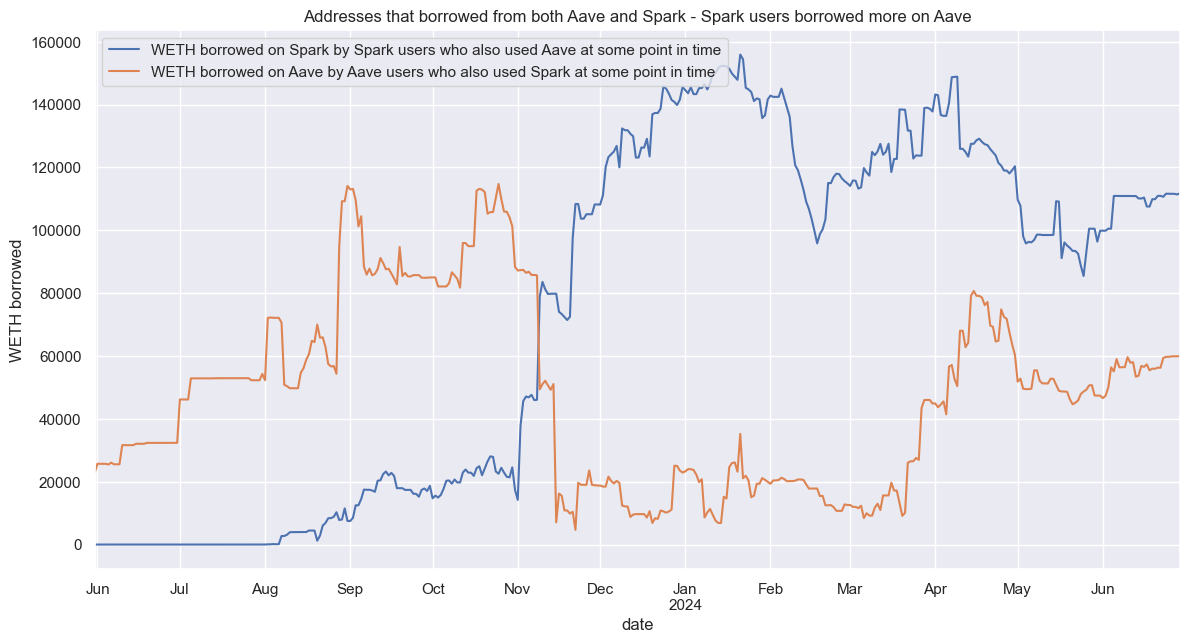

In [32]:
#6. Spark users who did not use Aave at all: WETH borrowed on Spark (control)
#7. Spark users who used Aave at some point: WETH borrowed on Spark (treatment)

plt.figure(figsize=(14,7))

daily_sum_spark_aave = pd.DataFrame(WETH_daily2.groupby(['token_address', "spark_never_aave", 'date'])['cumulative_transfer2'].sum())
daily_sum_spark_aave.reset_index(inplace = True)
daily_sum_spark_aave_trunc = daily_sum_spark_aave.loc[daily_sum_spark_aave['date']>'2023-05-30']
daily_sum_spark_aave_trunc['Protocol'] = np.where(daily_sum_spark_aave_trunc['token_address']=="0x2e7576042566f8d6990e07a1b61ad1efd86ae70d", "Spark", "Aave") 

daily_sum_spark_aave_intersect = pd.DataFrame(WETH_daily2.groupby(['token_address', "aave_spark_all", 'date'])['cumulative_transfer2'].sum())
daily_sum_spark_aave_intersect.reset_index(inplace = True)
daily_sum_spark_aave_intersect_trunc = daily_sum_spark_aave_intersect.loc[daily_sum_spark_aave_intersect['date']>'2023-05-30']
daily_sum_spark_aave_intersect_trunc['Protocol'] = np.where(daily_sum_spark_aave_intersect_trunc['token_address']=="0x2e7576042566f8d6990e07a1b61ad1efd86ae70d", "Spark", "Aave") 


daily_sum_aave_spark = pd.DataFrame(WETH_daily2.groupby(['token_address', "aave_never_spark", 'date'])['cumulative_transfer2'].sum())
daily_sum_aave_spark.reset_index(inplace = True)
daily_sum_aave_spark_trunc = daily_sum_aave_spark.loc[daily_sum_aave_spark['date']>'2023-05-30']
daily_sum_aave_spark_trunc['Protocol'] = np.where(daily_sum_aave_spark_trunc['token_address']=="0x2e7576042566f8d6990e07a1b61ad1efd86ae70d", "Spark", "Aave") 



spark_aave_intersect= daily_sum_spark_aave_intersect_trunc.loc[(daily_sum_spark_aave_intersect_trunc['Protocol']=="Spark") & (daily_sum_spark_aave_intersect_trunc['aave_spark_all']==1)].set_index('date')
spark_never_aave = daily_sum_spark_aave_trunc.loc[(daily_sum_spark_aave_trunc['Protocol']=="Spark") & (daily_sum_spark_aave_trunc['spark_never_aave']==1)].set_index('date')
aave_spark_intersect= daily_sum_spark_aave_intersect_trunc.loc[(daily_sum_spark_aave_intersect_trunc['Protocol']=="Aave") & (daily_sum_spark_aave_intersect_trunc['aave_spark_all']==1)].set_index('date')
aave_never_spark = daily_sum_aave_spark_trunc.loc[(daily_sum_aave_spark_trunc['Protocol']=='Aave') & (daily_sum_aave_spark_trunc['aave_never_spark']==1)].set_index('date')



spark_aave_intersect['cumulative_transfer2'].plot(label = "WETH borrowed on Spark by Spark users who also used Aave at some point in time")
#spark_never_aave['cumulative_transfer2'].plot(label = "WETH borrowed on Spark by Spark users who never used Aave")

aave_spark_intersect['cumulative_transfer2'].plot(label = "WETH borrowed on Aave by Aave users who also used Spark at some point in time")
#aave_never_spark['cumulative_transfer2'].plot(label = "WETH borrowed on Aave by Aave users who never used Spark")

plt.legend()
plt.title("Addresses that borrowed from both Aave and Spark - Spark users borrowed more on Aave")
plt.ylabel('WETH borrowed')


Text(0.5, 1.0, 'Aadresses active Pre-Merit reduced their borrowing Post-Merit, especially on Aave')

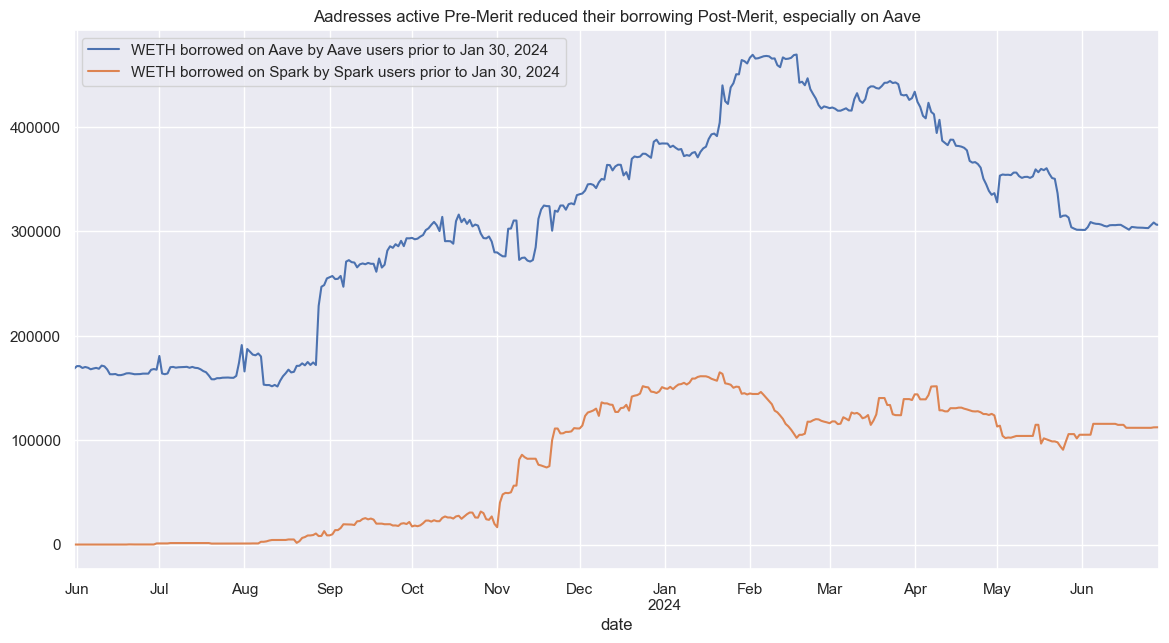

In [34]:
#6. Aave users pre-Merit
#7. Spark users pre-Merit


daily_sum_aave_pre = pd.DataFrame(WETH_daily2.groupby(['token_address', "aaveUser_pre", 'date'])['cumulative_transfer2'].sum())
daily_sum_aave_pre.reset_index(inplace = True)
daily_sum_aave_pre_trunc = daily_sum_aave_pre.loc[daily_sum_aave_pre['date']>'2023-05-30']
daily_sum_aave_pre_trunc['Protocol'] = np.where(daily_sum_aave_pre_trunc['token_address']=="0x2e7576042566f8d6990e07a1b61ad1efd86ae70d", "Spark", "Aave") 

daily_sum_spark_pre = pd.DataFrame(WETH_daily2.groupby(['token_address', "sparkUser_pre", 'date'])['cumulative_transfer2'].sum())
daily_sum_spark_pre.reset_index(inplace = True)
daily_sum_spark_pre_trunc = daily_sum_spark_pre.loc[daily_sum_spark_pre['date']>'2023-05-30']
daily_sum_spark_pre_trunc['Protocol'] = np.where(daily_sum_spark_pre_trunc['token_address']=="0x2e7576042566f8d6990e07a1b61ad1efd86ae70d", "Spark", "Aave") 

aave_pre_users = daily_sum_aave_pre_trunc.loc[(daily_sum_aave_pre_trunc['Protocol']=="Aave") & (daily_sum_aave_pre_trunc["aaveUser_pre"]==1)].set_index('date')
spark_pre_users = daily_sum_spark_pre_trunc.loc[(daily_sum_spark_pre_trunc['Protocol']=="Spark") & (daily_sum_spark_pre_trunc["sparkUser_pre"]==1)].set_index('date')


plt.figure(figsize=(14,7))


aave_pre_users['cumulative_transfer2'].plot(label = "WETH borrowed on Aave by Aave users prior to Jan 30, 2024")
spark_pre_users['cumulative_transfer2'].plot(label = "WETH borrowed on Spark by Spark users prior to Jan 30, 2024")

plt.legend()
plt.title("Aadresses active Pre-Merit reduced their borrowing Post-Merit, especially on Aave")

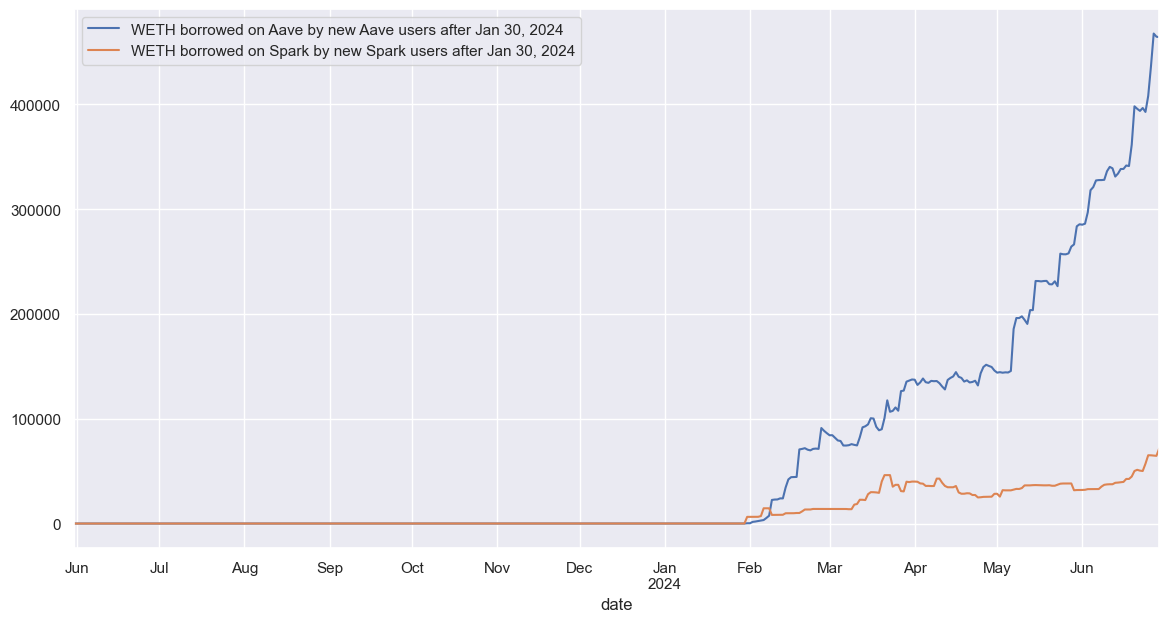

In [47]:
daily_sum_aave_post_only = pd.DataFrame(WETH_daily2.groupby(['token_address', "aaveUser_post_only", 'date'])['cumulative_transfer2'].sum())
daily_sum_aave_post_only.reset_index(inplace = True)
daily_sum_aave_post_only_trunc = daily_sum_aave_post_only.loc[daily_sum_aave_post_only['date']>'2023-05-30']
daily_sum_aave_post_only_trunc['Protocol'] = np.where(daily_sum_aave_post_only_trunc['token_address']=="0x2e7576042566f8d6990e07a1b61ad1efd86ae70d", "Spark", "Aave") 


daily_sum_spark_post_only = pd.DataFrame(WETH_daily2.groupby(['token_address', "sparkUser_post_only", 'date'])['cumulative_transfer2'].sum())
daily_sum_spark_post_only.reset_index(inplace = True)
daily_sum_spark_post_only_trunc = daily_sum_spark_post_only.loc[daily_sum_spark_post_only['date']>'2023-05-30']
daily_sum_spark_post_only_trunc['Protocol'] = np.where(daily_sum_spark_post_only_trunc['token_address']=="0x2e7576042566f8d6990e07a1b61ad1efd86ae70d", "Spark", "Aave") 



aave_post_only_users = daily_sum_aave_post_only_trunc.loc[(daily_sum_aave_post_only_trunc['Protocol']=="Aave") & (daily_sum_aave_post_only_trunc["aaveUser_post_only"]==1)].set_index('date')
spark_post_only_users = daily_sum_spark_post_only_trunc.loc[(daily_sum_spark_post_only_trunc['Protocol']=="Spark") & (daily_sum_spark_post_only_trunc["sparkUser_post_only"]==1)].set_index('date')


plt.figure(figsize=(14,7))


aave_post_only_users['cumulative_transfer2'].plot(label = "WETH borrowed on Aave by new Aave users after Jan 30, 2024")
spark_post_only_users['cumulative_transfer2'].plot(label = "WETH borrowed on Spark by new Spark users after Jan 30, 2024")


plt.legend()
#plt.title("Aadresses active Pre-Merit reduced their borrowing Post-Merit, especially on Aave")



#### Plot active users over time for both Spark and Aave WETH market

In [26]:
## sum the number users of each token with postiive balance each day:

users = WETH_daily2.groupby(['token_address', 'date'])[['active','positive']].sum()
userCount = pd.DataFrame(users)

# "active_address_count" include those with positive balance or made transactions
userCount.rename(columns={'active': "active_address_count", "positive": "positive_address_count"}, inplace = True)

userCount.reset_index(inplace=True)

In [ ]:
spark_aave_intersect['cumulative_transfer2'].plot(label = "WETH borrowed on Spark by Spark users who also used Aave at some point in time")